# Temperature prediciton

Jiahe Jiang

Date: June 8th, 2024

## Imports

In [1]:
import os

%matplotlib inline
import string
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import re
import sys
from hashlib import sha1

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

## Introductions

Understanding and predicting weather patterns is crucial for numerous sectors, including agriculture (Hammer et al., 2001), transportation, and public safety. Accurate weather predictions can mitigate the impact of natural disasters, enhance crop yield forecasts, and improve the efficiency of transportation systems. With the advent of machine learning, the ability to analyze vast amounts of weather data and generate reliable predictions has significantly advanced (Chen et al., 2023).

In this project, we will utilize the [Weather Data](https://www.kaggle.com/datasets/prasad22/weather-data/data) dataset to predict temperatures across multiple American cities using machine learning techniques. This comprehensive dataset comprises synthetic weather data for ten distinct locations: New York, Los Angeles, Chicago, Houston, Phoenix, Philadelphia, San Antonio, San Diego, Dallas, and San Jose. The primary objective is to estimate the potential temperature in a given area, denoted by the "Temperature_C" column in the dataset. The remaining columns will be used as features for the prediction model.

By leveraging machine learning, we aim to develop models that can accurately forecast temperature variations, which is essential for effective climate adaptation strategies and urban planning (Karpatne et al., 2018). Studies have shown that advanced predictive models can significantly improve the accuracy of weather forecasts, benefiting society at large (Tao et al., 2022). This project contributes to the growing body of research in weather prediction and showcases the potential of machine learning in addressing complex environmental challenges.

The dataset includes 1 million data points for each parameter, capturing the following features:

- `Location`: The city where the weather data was simulated
- `Date_Time`: The date and time when the weather data was recorded.
- `Temperature_C`: The temperature in Celsius at the given location and time.
- `Humidity_pct`: The humidity percentage at the given location and time.
- `Precipitation_mm`: The precipitation in millimeters at the given location and time.
- `Wind_Speed_kmh`: The wind speed in kilometers per hour at the given location and time.

## Loading and splitting the dataset.

> Load the dataset from `data/weather_data.csv`.

In [2]:
# Load the data
weather_df = pd.read_csv('data/weather_data.csv', delimiter=',')

# Convert 'Date_Time' to datetime
weather_df["Date_Time"] = pd.to_datetime(weather_df["Date_Time"])

# Extract datetime features
weather_df['Year'] = weather_df['Date_Time'].dt.year
weather_df['Month'] = weather_df['Date_Time'].dt.month
weather_df['Day'] = weather_df['Date_Time'].dt.day
weather_df['Hour'] = weather_df['Date_Time'].dt.hour

# Drop the 'Date_Time' column
weather_df.drop(columns=["Date_Time"], inplace=True)

# Display the first few rows of the dataframe
weather_df.head()

,Location,Temperature_C,Humidity_pct,Precipitation_mm,Wind_Speed_kmh,Year,Month,Day,Hour
0,San Diego,10.683001,41.195754,4.020119,8.233540,2024,1,14,21
1,San Diego,8.734140,58.319107,9.111623,27.715161,2024,5,17,15
2,San Diego,11.632436,38.820175,4.607511,28.732951,2024,5,11,9
3,Philadelphia,-8.628976,54.074474,3.183720,26.367303,2024,2,26,17
4,San Antonio,39.808213,72.899908,9.598282,29.898622,2024,4,29,13


In [3]:
weather_df.shape

(1000000, 9)

The dataset `weather_df` contains a total of 1000000 rows and 9 columns.

> Split the data into train (80%) and test (20%) portions with `random_state=123`.

In [4]:
# 20% of the data will be used for testing, and 80% for training, random_state=123 ensures reproducibility of the split
train_df, test_df = train_test_split(
    weather_df, test_size=0.2, random_state=123
) 
train_df

,Location,Temperature_C,Humidity_pct,Precipitation_mm,Wind_Speed_kmh,Year,Month,Day,Hour
720025,Phoenix,30.237636,87.770714,3.035020,16.097933,2024,4,16,14
123815,San Antonio,8.630216,60.725342,4.553492,6.795818,2024,3,3,10
717911,Chicago,19.689666,39.142721,0.964295,2.148755,2024,3,23,9
691720,Phoenix,7.278727,39.753964,6.173982,26.426173,2024,1,28,20
951608,San Jose,38.329105,44.391912,6.266054,25.373428,2024,4,20,16
...,...,...,...,...,...,...,...,...,...
192476,San Diego,9.627265,69.213180,3.265939,15.891991,2024,4,29,10
17730,New York,9.621483,50.344610,5.596098,9.938645,2024,1,8,9
28030,Houston,35.288456,33.751726,5.831077,11.120886,2024,4,20,6
277869,Dallas,30.777057,30.840277,1.376490,15.577100,2024,1,13,3


## Exploratory Data Analysis (EDA) 
> Understand the data distribution and relationships.

In [5]:
train_df.describe()

,Temperature_C,Humidity_pct,Precipitation_mm,Wind_Speed_kmh,Year,Month,Day,Hour
count,800000.000000,800000.000000,800000.000000,800000.000000,800000.0,800000.000000,800000.000000,800000.000000
mean,14.783371,60.028984,5.109975,15.000863,2024.0,2.817960,14.840620,11.478891
std,14.477668,17.317966,2.948729,8.659518,0.0,1.341097,8.635569,6.916772
min,-19.969311,30.000009,0.000009,0.000051,2024.0,1.000000,1.000000,0.000000
25%,2.278901,45.022866,2.578507,7.505790,2024.0,2.000000,7.000000,5.000000
50%,14.794918,60.030984,5.112343,14.994127,2024.0,3.000000,14.000000,11.000000
75%,27.263272,75.041311,7.613761,22.515735,2024.0,4.000000,22.000000,17.000000
max,39.999801,89.999977,14.971583,29.999973,2024.0,5.000000,31.000000,23.000000


From the `count` column, we observe that all entries have complete data (**no missing values**). Additionally, the `std` column for `Year` is 0, indicating that all data were collected in 2024. Therefore, the `Year` column is not useful for predicting the target variable.

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 800000 entries, 720025 to 773630
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Location          800000 non-null  object 
 1   Temperature_C     800000 non-null  float64
 2   Humidity_pct      800000 non-null  float64
 3   Precipitation_mm  800000 non-null  float64
 4   Wind_Speed_kmh    800000 non-null  float64
 5   Year              800000 non-null  int32  
 6   Month             800000 non-null  int32  
 7   Day               800000 non-null  int32  
 8   Hour              800000 non-null  int32  
dtypes: float64(4), int32(4), object(1)
memory usage: 48.8+ MB


The training dataset contains 800,000 entries with 9 columns, consisting of 4 columns of *type float64*, 4 columns of *type int64* and 1 column of *type object*.

> Feature Engineering

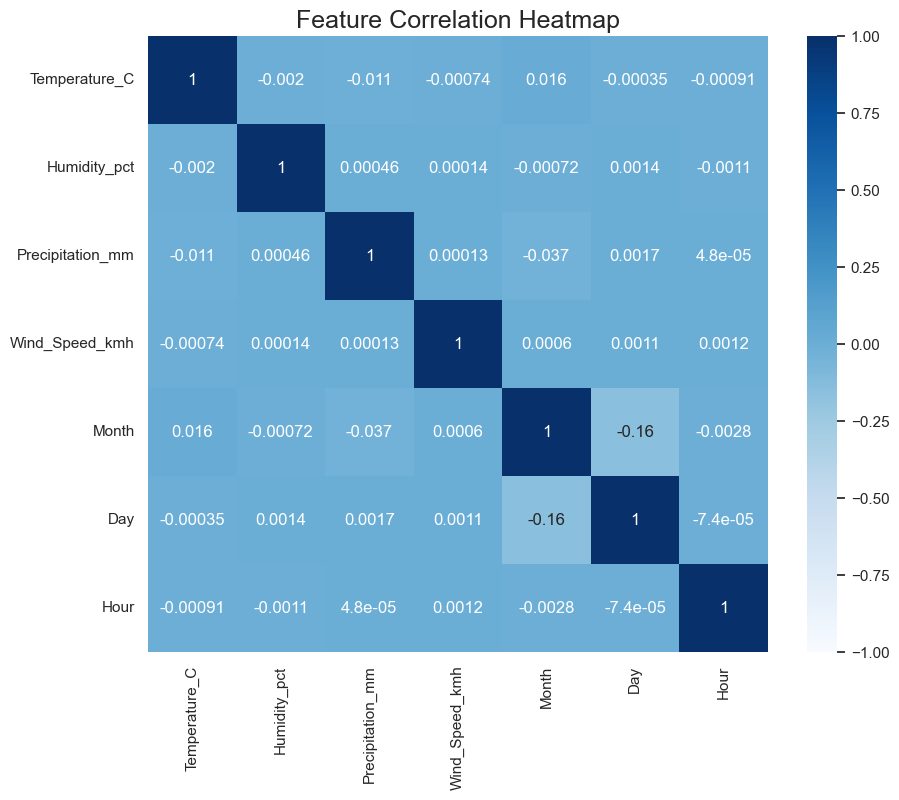

In [7]:
import seaborn as sns

# Calculate the correlation matrix
# Concatenating the 'Temperature_C' column with the rest of the features excluding 'Location' and 'Year'
cor = pd.concat([train_df["Temperature_C"], train_df.drop(columns=["Location", "Year", "Temperature_C"])], axis=1).corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Set up the seaborn settings
sns.set(font_scale=1.0)

# Draw the heatmap with the correlation matrix
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues, vmin=-1, vmax=1)

# Add the title to the heatmap
plt.title('Feature Correlation Heatmap', fontsize=18)

# Show the plot
plt.show()


In [8]:
X_train = train_df.drop(columns=["Temperature_C"])
y_train = train_df["Temperature_C"]

X_test = test_df.drop(columns=["Temperature_C"])
y_test = test_df["Temperature_C"]

## Preprocess the data

In [23]:
# Retrieves the unique values in the Location column, which are the names of various cities.
train_df["Location"].unique()

array(['Phoenix', 'San Antonio', 'Chicago', 'San Jose', 'Houston',
       'Philadelphia', 'Dallas', 'New York', 'San Diego', 'Los Angeles'],
      dtype=object)

In [24]:
# Define features
drop_features = ["Year"]
numerical_features = ["Humidity_pct", "Precipitation_mm", "Wind_Speed_kmh"]
categorical_features = ["Location"]
passthrough_features = ["Month", "Day", "Hour"]

In [26]:
# Fit the preprocessor
preprocessor.fit(X_train)

# Retrieve the names of one-hot encoded columns
ohe_columns = list(
    preprocessor.named_transformers_["onehotencoder"].get_feature_names_out(categorical_features)
)

# Combine numerical features, one-hot encoded columns and passthrough features
new_columns = numerical_features + ohe_columns + passthrough_features 

# Transform the data and create a DataFrame with new column names
X_train_enc = pd.DataFrame(
    preprocessor.transform(X_train),
    index=X_train.index,
    columns=new_columns
)

X_train_enc

,Humidity_pct,Precipitation_mm,Wind_Speed_kmh,Location_Chicago,Location_Dallas,Location_Houston,Location_Los Angeles,Location_New York,Location_Philadelphia,Location_Phoenix,Location_San Antonio,Location_San Diego,Location_San Jose,Month,Day,Hour
720025,1.601906,-0.703678,0.126690,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,16.0,14.0
123815,0.040210,-0.188720,-0.947518,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,3.0,10.0
717911,-1.206047,-1.405922,-1.484161,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,23.0,9.0
691720,-1.170751,0.360836,1.319394,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,28.0,20.0
951608,-0.902940,0.392060,1.197823,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,20.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192476,0.530328,-0.625367,0.102907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,29.0,10.0
17730,-0.559210,0.164858,-0.584585,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,9.0
28030,-1.517342,0.244547,-0.448060,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,20.0,6.0
277869,-1.685459,-1.266134,0.066544,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,13.0,3.0


> Feature Engineering

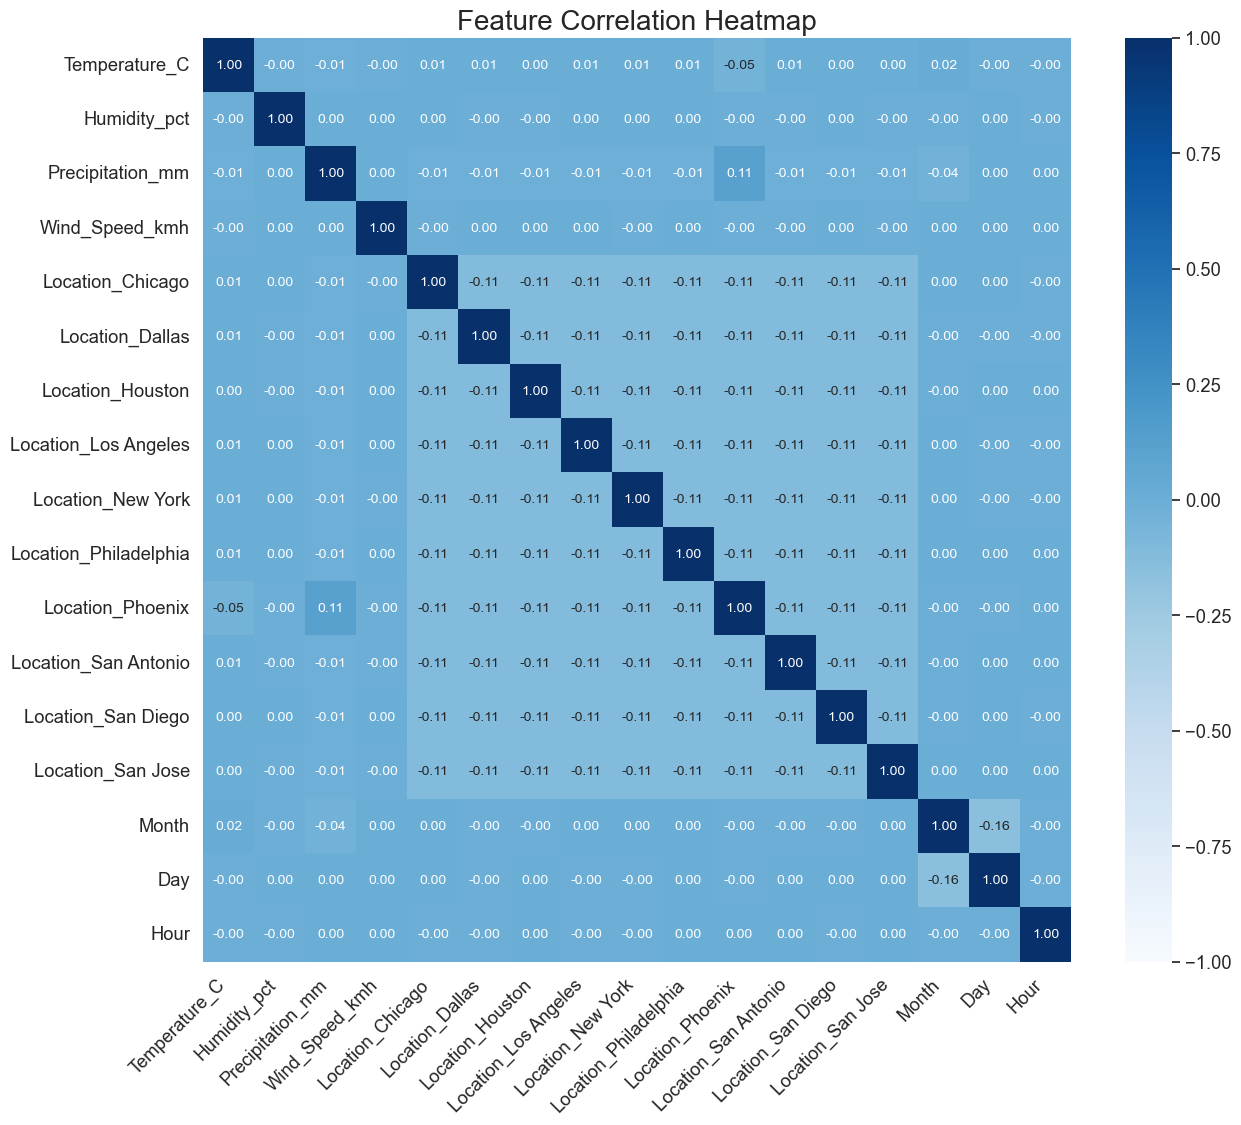

In [27]:
import seaborn as sns

# Concatenate y_train with X_train_enc
combined_df = pd.concat([y_train, X_train_enc], axis=1)

# Calculate the correlation matrix
cor = combined_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(14, 12))

# Set up the seaborn settings
sns.set(font_scale=1.2)

# Draw the heatmap with the correlation matrix
sns.heatmap(cor, annot=True, fmt=".2f", cmap=plt.cm.Blues, vmin=-1, vmax=1, annot_kws={"size": 10})

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

# Add the title to the heatmap
plt.title('Feature Correlation Heatmap', fontsize=20)

# Show the plot
plt.show()

Based on the feature correlation heatmap, the following findings can be concluded:

1. **Temperature_C**:
   - `Temperature_C` has very weak correlations with all other features. The highest correlation observed is with `Location_Phoenix` at -0.05, which indicates a negligible negative relationship.

2. **Humidity_pct**:
   - `Humidity_pct` shows almost no correlation with other features, suggesting that humidity levels are independent of the other variables in this dataset.

3. **Precipitation_mm**:
   - `Precipitation_mm` has a very weak positive correlation with `Location_Phoenix` (0.11), indicating a slight tendency for increased precipitation in Phoenix. However, this is still a very weak relationship.

4. **Wind_Speed_kmh**:
   - `Wind_Speed_kmh` shows no significant correlation with other features, indicating that wind speed is independent of the other variables.

5. **Temporal Features**:
   - The `Month` feature has a weak negative correlation with the `Day` feature (-0.16), which might be due to the nature of the data collection or specific characteristics of the dataset.
   - Other temporal features (`Day` and `Hour`) exhibit very weak correlations with the non-temporal features and with each other.

6. **Location Features**:
   - The one-hot encoded location features show perfect correlations (1.00) with themselves and an equal negative correlation (-0.11) with other locations. This is expected due to the nature of one-hot encoding.
   - The weak correlations between locations and other features, such as a slight negative correlation between `Location_Phoenix` and `Temperature_C` (-0.05), suggest minimal linear relationships between specific locations and weather conditions.

### General Observations:
- **Overall Weak Correlations**: The correlation values between most features are close to zero, indicating no strong linear relationships within the dataset.
- **Independence of Features**: The weak correlations suggest that the features in this dataset are largely independent of one another.
- **Need for Advanced Analysis**: The lack of strong linear relationships indicates that further analysis, potentially using non-linear methods or more sophisticated feature engineering, may be necessary to uncover more complex relationships within the data. 

## Select and evaluate machine learning models.

> BaseLine

## Hyperparameter optimization 

## Interpret the results and make conclusions.

## Reference

1. Chen, L., Han, B., Wang, X., Zhao, J., Yang, W., & Yang, Z. (2023). Machine learning methods in weather and climate applications: A survey. Applied Sciences, 13(21), 12019.
2. Hammer, G. L., Hansen, J. W., Phillips, J. G., Mjelde, J. W., Hill, H., Love, A., & Potgieter, A. (2001). Advances in application of climate prediction in agriculture. Agricultural systems, 70(2-3), 515-553.
3. Karpatne, A., Ebert-Uphoff, I., Ravela, S., Babaie, H. A., & Kumar, V. (2018). Machine learning for the geosciences: Challenges and opportunities. IEEE Transactions on Knowledge and Data Engineering, 31(8), 1544-1554.
4. Tao, H., Awadh, S. M., Salih, S. Q., Shafik, S. S., & Yaseen, Z. M. (2022). Integration of extreme gradient boosting feature selection approach with machine learning models: application of weather relative humidity prediction. Neural Computing and Applications, 34(1), 515-533.